In [834]:
!pip install p3_data

In [835]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm
import seaborn as sns
import json
from io import StringIO
import importlib

In [836]:
import p3_data
from p3_data import (glob_file_list, load_json_from_file, merge_dicts, plot_groups, 
    get_varying_column_names, filter_dataframe, take_varying_columns,
    load_json_records_as_dataframe)

In [1197]:
# Load result files from P3 Test Driver
src_files = []

# Pulsar 2.6.0 ecs s3 tier2 07.07.2020

## attempt1 brokers out of direct memory
#src_files += ['../../../../../tests/Pulsar-ecs-s3-tier2-Redhook/Pulsar-2.6.0-tier2-ecs-s3-07.07.2020-10k-16p-18tests-attempt1-broker-outofdirectmem/data/p3_test_driver/results/*.json']

## attempt2 bookies out of direct memory
#src_files += ['../../../../../tests/Pulsar-ecs-s3-tier2-Redhook/pulsar-2.6.0-tier2-ecs-s3-07.07.2020-10k-16p-19tests-attempt2-bk-outofdirectmem/data/p3_test_driver/results/*.json']

## attempt3 broker out of direct memory
#src_files += ['../../../../../tests/Pulsar-ecs-s3-tier2-Redhook/pulsar-2.6.0-tier2-ecs-s3-07.07.2020-10k-16p-19tests-attempt3-broker-directmemOOM/data/p3_test_driver/results/*.json']
#src_files += ['../../../../../tests/Pulsar-ecs-s3-tier2-Redhook/pulsar-2.6.0-tier2-ecs-s3-07.07.2020-10k-16p-19tests-attempt3-broker-directmemOOM/data/p3_test_driver/results_cleared/*.json']

# Pulsar 2.6.0 ecs s3 tier2 07.07.2020
## attempt4 broker out of direct memory - 52 tests
#src_files += ['../../../../../tests/Pulsar-ecs-s3-tier2-Redhook/pulsar-2.6.0-tier2-ecs-s3-07.07.2020-10k-16p-52tests-attempt4/data/p3_test_driver/results_cleared/*.json']

# pulsar-2.6.0-no-tiered-10.07.2020-46tests-success
#src_files += ['../../../../../tests/Pulsar-ecs-s3-tier2-Redhook/pulsar-2.6.0-no-tiered-10.07.2020-46tests-success/data/p3_test_driver/results_cleared/*.json']
#---------------------------------------------------------

### Pulsar 2.5.2 15.06.2020 44 tests different amount of workers
# src_files += ['../../../../../tests/pulsar_2.5.2_44_tests_15.06/data/p3_test_driver/results/*.json']

### Pulsar 2.5.2 17.06.2020 44 tests different amount of workers
src_files += ['../../../../../tests/Pulsar-2.5.2-17.06.20-44tests/data/p3_test_driver/results_cleared/*.json']

# Pravega 0.8.0-2577.15b0f5eb9 tier2 29.06.2020
#src_files += ['../../../../tests/pravega-15b0f5eb9-tier2-29.06.2020-10k-100b/pravega-0.8.0-2577.15b0f5eb9-tier2-10k-28tests-29.06.2020/data/p3_test_driver/results/*.json']

# pravega-0.8.0-2656.1c40f1e-no_netty_Isilon-nfs-tier2 09.07.2020 48 tests success
#src_files += ['../../../../../tests/Pravega-1c40f1e-NO_NETTY-nfs-Isilon-tier2-48tests-succsess-09.07.2020/data/p3_test_driver/results/*.json']

### PRAVEGA 15b0f5eb9 (master) Isilon nfs omb 2b28b32 (no_netty) 09.07.2020 48tests success
src_files += ['../../../../../tests/PRAVEGA-15b0f5eb9-Isilon-nfs-omb-2b28b32-09.07.2020-48tests/data/p3_test_driver/results/*.json']

raw_df = load_json_records_as_dataframe(src=src_files, ignore_error=True)

Loading records from 85 files...


In [1198]:
# Clean raw results
def clean_result(result):
    try:
        r = result.copy()
        r['utc_begin'] = pd.to_datetime(r['utc_begin'], utc=True)
        r['utc_end'] = pd.to_datetime(r['utc_end'], utc=True)
        r['git_commit'] = r['git_commit'].split(' ')[0]
        r['driverName'] = r['driver']['name']
        if r['driverName'] == 'Pulsar':
            r = merge_dicts(r, r['driver']['client']['persistence'])
        r = merge_dicts(r, r['workload'])
        del r['workload']
        r = merge_dicts(r, r['omb_results'])
        if 'ansible_vars' in r and isinstance(r['ansible_vars'], dict):
            r = merge_dicts(r, r['ansible_vars'])
        if r['driverName'] == 'Pravega':
            if 'pravegaVersion' not in r:
                r['pravegaVersion'] = '1c40f1e-no_netty_Isilon-nfs-tier2'
            r['pravegaVersion'] = r['pravegaVersion'].replace('-SNAPSHOT','')
        for k in list(r.keys()):
            if 'Quantiles' in k:
                r[k] = pd.Series(data=[float(q) for q in r[k].keys()], index=list(r[k].values())).sort_index() / 100
            elif isinstance(r[k], list) and 'Rate' in k:
                r[k] = pd.Series(r[k])
                r['%sMean' % k] = r[k].mean()
        r['numWorkloadWorkers'] = int(r.get('numWorkers', 0))
        r['throttleEventsPerSec'] = r['producerRate']
        r['publishRateEventsPerSecMean'] = r['publishRateMean']
        r['consumeRateEventsPerSecMean'] = r['consumeRateMean']
        r['publishRateMBPerSecMean'] = r['publishRateMean'] * r['messageSize'] * 1e-6
        r['consumeRateMBPerSecMean'] = r['consumeRateMean'] * r['messageSize'] * 1e-6
        r['publishLatencyMsAvg'] = r['aggregatedPublishLatencyAvg']
        r['publishLatencyMs50Pct'] = r['aggregatedPublishLatency50pct']
        r['publishLatencyMs99Pct'] = r['aggregatedPublishLatency99pct']
        r['endToEndLatencyMsAvg'] = r['aggregatedEndToEndLatencyAvg']
        r['endToEndLatencyMs50Pct'] = r['aggregatedEndToEndLatency50pct']
        r['endToEndLatencyMs99Pct'] = r['aggregatedEndToEndLatency99pct']
        
        if r['driverName'] == 'Pulsar':
            r['version'] = r['pulsarVersion']
            
        if r['driverName'] == 'Pravega':    
            r['version'] = r['pravegaVersion']   
        
        return pd.Series(r)
    except Exception as e:
        print('ERROR: %s: %s' % (r['test_uuid'], e))
        # raise e

In [1199]:
# r = clean_result(raw_df.iloc[-1])
# pd.DataFrame(r)

In [1200]:
clean_df = raw_df.apply(clean_result, axis=1)
clean_df = clean_df.set_index('test_uuid', drop=False)
clean_df = clean_df[clean_df.error==False]
clean_df = clean_df.sort_values(['utc_begin'])

In [1201]:
# Show list of columns
clean_df.columns.values

array(['ackQuorum', 'aggregatedEndToEndLatency50pct',
       'aggregatedEndToEndLatency75pct', 'aggregatedEndToEndLatency95pct',
       'aggregatedEndToEndLatency9999pct',
       'aggregatedEndToEndLatency999pct',
       'aggregatedEndToEndLatency99pct', 'aggregatedEndToEndLatencyAvg',
       'aggregatedEndToEndLatencyMax',
       'aggregatedEndToEndLatencyQuantiles',
       'aggregatedPublishLatency50pct', 'aggregatedPublishLatency75pct',
       'aggregatedPublishLatency95pct', 'aggregatedPublishLatency9999pct',
       'aggregatedPublishLatency999pct', 'aggregatedPublishLatency99pct',
       'aggregatedPublishLatencyAvg', 'aggregatedPublishLatencyMax',
       'aggregatedPublishLatencyQuantiles', 'ansible', 'ansible_vars',
       'aws-ec2', 'backlog', 'bookkeeperVersion', 'build',
       'command_timed_out', 'consumeRate', 'consumeRateEventsPerSecMean',
       'consumeRateMBPerSecMean', 'consumeRateMean',
       'consumerBacklogSizeGB', 'consumerPerSubscription',
       'deduplicationE

In [1202]:
# Define columns that identify test parameters
param_cols = [
    'numWorkloadWorkers',
    'topics',
    'partitionsPerTopic',
    'producersPerTopic',
    'subscriptionsPerTopic',
    'consumerPerSubscription',
    'testDurationMinutes',
    'keyDistributor',
    'git_commit',
    'driverName',
    'version'
]

In [1203]:
# Define columns that are the output of the experiments
output_cols = [
    'publishRateEventsPerSecMean',
    'consumeRateEventsPerSecMean',
    'consumeRateMBPerSecMean',
    'publishRateMBPerSecMean',
    'publishLatencyMs50Pct',
    'publishLatencyMs99Pct',
    'endToEndLatencyMs50Pct',
    'endToEndLatencyMs99Pct',
    'throttleEventsPerSec',
    'utc_begin',    
]

In [1204]:
cols = param_cols + output_cols

In [1205]:
# View most recent results
clean_df[cols].tail(38).T

test_uuid,e9c6311a-d68d-4890-8557-e9689e3728c7,5d2a5d62-eb01-4743-b6a3-d946c96dfdd0,43396b91-fb96-498e-9f80-c746eb940e00,5afc1c15-1721-4aba-9d29-c959d9320c74,81d79f5c-2b89-4c1c-916d-1fd899bfc40c,c0aedc56-8164-4af9-98c0-c509babb5ac6,1da4f11c-cda3-433c-bddd-f45bb680ed11,8b122058-586e-4ec3-9664-1129487c8053,4e5bb630-2d28-4bd1-9838-f74db7d24b2c,5aabde3d-7062-4a67-b133-b39a05a6e023,...,69e46b30-3626-4e3e-b38d-4eedb3a5028e,8b3a907a-798d-4a10-9f4d-5bfe98b10361,b5df29e4-14fd-4bd7-b69d-10c7d6a6847c,66e13a39-cca0-4cfc-9f0b-7079900d6967,9dadef8b-572f-428c-8900-03e5a0ac9f1c,ba0c2865-d92c-4da9-be7a-09ab54a610d8,d4110a18-26c6-4d7b-a105-76154684f4fc,1bb8a954-ecc7-495e-a8ed-0b92488f090d,6bb93fc4-8720-4c01-9d74-3cfc61833c67,c1ce9307-009b-450b-a367-2e045f5945d0
numWorkloadWorkers,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
topics,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
partitionsPerTopic,16,16,16,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
producersPerTopic,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
subscriptionsPerTopic,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
consumerPerSubscription,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
testDurationMinutes,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
keyDistributor,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,...,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY
git_commit,88dbf86,88dbf86,88dbf86,88dbf86,88dbf86,88dbf86,88dbf86,88dbf86,88dbf86,88dbf86,...,88dbf86,88dbf86,88dbf86,88dbf86,88dbf86,88dbf86,88dbf86,88dbf86,88dbf86,88dbf86
driverName,Pravega,Pravega,Pravega,Pravega,Pravega,Pravega,Pravega,Pravega,Pravega,Pravega,...,Pravega,Pravega,Pravega,Pravega,Pravega,Pravega,Pravega,Pravega,Pravega,Pravega


In [1206]:
# Export to CSV
#clean_df[cols].to_csv('openmessaging-benchmark-results.csv')

In [1207]:
# df = clean_df[cols]
# df = df.sort_values(['messageSize','numWorkloadWorkers','producersPerTopic','throttleEventsPerSec','utc_begin'])
# df.head()

In [1208]:
# View distinct values of pravegaVersion and test counts
clean_df.groupby(['version']).size()

version
0.8.0-2656.15b0f5eb9-no_netty-client-Isilon-tier2    48
2.5.2                                                37
dtype: int64

In [1209]:
# First level of filtering
filt_df = filter_dataframe(
    clean_df,
    #version='2.6.0-not-tiered',
    #driverName='Pulsar',
    #pulsarVersion='2.5.2',
    #pravegaVersion='0.8.0-2656.15b0f5eb9-no_netty-client-Isilon-tier2',
    numWorkloadWorkers=4, 
    topics=4,
    testDurationMinutes=2,
   # size_of_test_batch=(2,1000), # between
   # aggregatedEndToEndLatency50pct=(1,1e6),
)
# filt_df = filt_df[filt_df.size_of_test_batch > 1]
len(filt_df)

85

In [1210]:
def latency_vs_publish_throughput_table(df):
    result_df = (df
        .set_index(['publishRateMBPerSecMean'])
        .sort_index()
        [[
            'aggregatedPublishLatency50pct',
            'aggregatedPublishLatency95pct',
            'aggregatedPublishLatency99pct',
            'aggregatedEndToEndLatency50pct',
            'aggregatedEndToEndLatency95pct',
            'aggregatedEndToEndLatency99pct',
            'test_uuid',
        ]]
        .rename(columns=dict(
            aggregatedPublishLatency50pct='Publish Latency p50',
            aggregatedPublishLatency95pct='Publish Latency p95',
            aggregatedPublishLatency99pct='Publish Latency p99',
            aggregatedEndToEndLatency50pct='E2E Latency p50',
            aggregatedEndToEndLatency95pct='E2E Latency p95',
            aggregatedEndToEndLatency99pct='E2E Latency p99',
        ))
        )
    result_df.index.name = 'Achieved Publish Throughput (MB/s)'
    return result_df

In [1211]:
def latency_vs_consume_throughput_table(df):
    result_df = (df
        .set_index(['consumeRateMBPerSecMean'])
        .sort_index()
        [[
            'aggregatedPublishLatency50pct',
            'aggregatedPublishLatency95pct',
            'aggregatedPublishLatency99pct',
            'aggregatedEndToEndLatency50pct',
            'aggregatedEndToEndLatency95pct',
            'aggregatedEndToEndLatency99pct',
            'test_uuid',
        ]]
        .rename(columns=dict(
            aggregatedPublishLatency50pct='Publish Latency p50',
            aggregatedPublishLatency95pct='Publish Latency p95',
            aggregatedPublishLatency99pct='Publish Latency p99',
            aggregatedEndToEndLatency50pct='E2E Latency p50',
            aggregatedEndToEndLatency95pct='E2E Latency p95',
            aggregatedEndToEndLatency99pct='E2E Latency p99',
        ))
        )
    result_df.index.name = 'Achieved Consume Throughput (MB/s)'
    return result_df

In [1212]:
def latency_vs_provided_rate_table(df):
    result_df = (df
        .set_index(['throttleEventsPerSec'])
        .sort_index()
        [[
            'aggregatedPublishLatency50pct',
            'aggregatedPublishLatency95pct',
            'aggregatedPublishLatency99pct',
            'aggregatedEndToEndLatency50pct',
            'aggregatedEndToEndLatency95pct',
            'aggregatedEndToEndLatency99pct',
            'test_uuid',
        ]]
        .rename(columns=dict(
            aggregatedPublishLatency50pct='Publish Latency p50',
            aggregatedPublishLatency95pct='Publish Latency p95',
            aggregatedPublishLatency99pct='Publish Latency p99',
            aggregatedEndToEndLatency50pct='E2E Latency p50',
            aggregatedEndToEndLatency95pct='E2E Latency p95',
            aggregatedEndToEndLatency99pct='E2E Latency p99',
        ))
        )
    result_df.index.name = 'Throttle Events Per Second'
    return result_df

In [1213]:
def plot_latency_vs_consume_throughput(df):
    assert len(df.messageSize.drop_duplicates().values) == 1
    messageSize = df.messageSize.iloc[0]
    partitionsPerTopic = df.partitionsPerTopic.iloc[0]
    testDurationMinutes = df.testDurationMinutes.iloc[0]
    topics = df.topics.iloc[0]
    producersPerTopic = df.producersPerTopic.iloc[0]
    consumerPerSubscription = df.consumerPerSubscription.iloc[0]
    version = df.version.iloc[0]
    driver = df.driver.iloc[0]
    plot_df = latency_vs_consume_throughput_table(df)
    title = '%s %s 07.07.2020 attempt4, message Size %d, partitions: %d producersPerTopic: %d consumerPerSubscription: %d topics: %d  %dmin test' % (driver, version, messageSize, partitionsPerTopic, producersPerTopic, consumerPerSubscription, topics, testDurationMinutes)
    ax = plot_df.plot(
        logx=True, 
        logy=True,
        figsize=(10,8),
        grid=True, 
        title=title, 
        style=['x:b','x-.b','x-b','+:r','+-.r','+-r'])
    ax.set_ylabel('Latency (ms)');
    tick_formatter = matplotlib.ticker.LogFormatter()
    ax.xaxis.set_major_formatter(tick_formatter)
    ax.yaxis.set_major_formatter(tick_formatter)
    ax.grid('on', which='both', axis='both')

In [1214]:
def plot_latency_vs_publish_throughput(df):
    assert len(df.messageSize.drop_duplicates().values) == 1
    messageSize = df.messageSize.iloc[0]
    partitionsPerTopic = df.partitionsPerTopic.iloc[0]
    testDurationMinutes = df.testDurationMinutes.iloc[0]
    topics = df.topics.iloc[0]
    producersPerTopic = df.producersPerTopic.iloc[0]
    consumerPerSubscription = df.consumerPerSubscription.iloc[0]
    version = df.version.iloc[0]
    driver = df.driver.iloc[0]
    plot_df = latency_vs_publish_throughput_table(df)
    title = '%s %s 07.07.2020 attempt4, message Size %d, partitions: %d producersPerTopic: %d consumerPerSubscription: %d topics: %d  %dmin test' % (driver, version, messageSize, partitionsPerTopic, producersPerTopic, consumerPerSubscription, topics, testDurationMinutes)
    ax = plot_df.plot(
        logx=True, 
        logy=True,
        figsize=(10,8),
        grid=True, 
        title=title, 
        style=['x:b','x-.b','x-b','+:r','+-.r','+-r'])
    ax.set_ylabel('Latency (ms)');
    tick_formatter = matplotlib.ticker.LogFormatter()
    ax.xaxis.set_major_formatter(tick_formatter)
    ax.yaxis.set_major_formatter(tick_formatter)
    ax.grid('on', which='both', axis='both')

In [1215]:
def plot_latency_vs_provided_rate(df):
    assert len(df.messageSize.drop_duplicates().values) == 1
    messageSize = df.messageSize.iloc[0]
    partitionsPerTopic = df.partitionsPerTopic.iloc[0]
    testDurationMinutes = df.testDurationMinutes.iloc[0]
    topics = df.topics.iloc[0]
    producersPerTopic = df.producersPerTopic.iloc[0]
    consumerPerSubscription = df.consumerPerSubscription.iloc[0]
    version = df.version.iloc[0]
    driver = df.driver.iloc[0]
    plot_df = latency_vs_provided_rate_table(df)
    title = '%s %s 07.07.2020 attempt4, message Size %d, partitions: %d producersPerTopic: %d consumerPerSubscription: %d topics: %d  %dmin test' % (driver, version, messageSize, partitionsPerTopic, producersPerTopic, consumerPerSubscription, topics, testDurationMinutes)
    ax = plot_df.plot(
        logx=True, 
        logy=True,
        figsize=(10,8),
        grid=True, 
        title=title, 
        style=['x:b','x-.b','x-b','+:r','+-.r','+-r'])
    ax.set_ylabel('Latency (ms)');
    tick_formatter = matplotlib.ticker.LogFormatter()
    ax.xaxis.set_major_formatter(tick_formatter)
    ax.yaxis.set_major_formatter(tick_formatter)
    ax.grid('on', which='both', axis='both')

In [1216]:
def plot_latency_vs_provided_rate_normal(df):
    assert len(df.messageSize.drop_duplicates().values) == 1
    messageSize = df.messageSize.iloc[0]
    partitionsPerTopic = df.partitionsPerTopic.iloc[0]
    testDurationMinutes = df.testDurationMinutes.iloc[0]
    topics = df.topics.iloc[0]
    producersPerTopic = df.producersPerTopic.iloc[0]
    consumerPerSubscription = df.consumerPerSubscription.iloc[0]
    version = df.version.iloc[0]
    driver = df.driver.iloc[0]
    plot_df = latency_vs_provided_rate_table(df)
    title = '%s %s 07.07.2020 attempt4, message Size %d, partitions: %d producersPerTopic: %d consumerPerSubscription: %d topics: %d  %dmin test' % (driver, version, messageSize, partitionsPerTopic, producersPerTopic, consumerPerSubscription, topics, testDurationMinutes)
    ax = plot_df.plot(
        logx=False, 
        logy=False,
        figsize=(10,8),
        grid=True, 
        title=title, 
        style=['x:b','x-.b','x-b','+:r','+-.r','+-r'])
    ax.set_ylabel('Latency (ms)');
    tick_formatter = matplotlib.ticker.LogFormatter()
    ax.xaxis.set_major_formatter(tick_formatter)
    ax.yaxis.set_major_formatter(tick_formatter)
    ax.grid('on', which='both', axis='both')

## Message Size 100 B

In [1217]:
filt_100_df = filter_dataframe(
    filt_df,
    messageSize=100,
    producersPerTopic=4,
    partitionsPerTopic=1,
    topics=4
)

In [1218]:
# View varying columns
take_varying_columns(filt_100_df[filt_100_df.producerRate==100000]).T

test_uuid


In [1219]:
# View distinct sets of parameters.
# There should only be one distinct set of parameters.
filt_100_df[param_cols].drop_duplicates().T

test_uuid,17f06e5a-903e-4404-b8e7-889b598b7631,a69af0c9-247e-4862-876b-b4a7fde5b323
numWorkloadWorkers,4,4
topics,4,4
partitionsPerTopic,1,1
producersPerTopic,4,4
subscriptionsPerTopic,1,1
consumerPerSubscription,4,4
testDurationMinutes,2,2
keyDistributor,NO_KEY,NO_KEY
git_commit,0efd5d1,88dbf86
driverName,Pulsar,Pravega


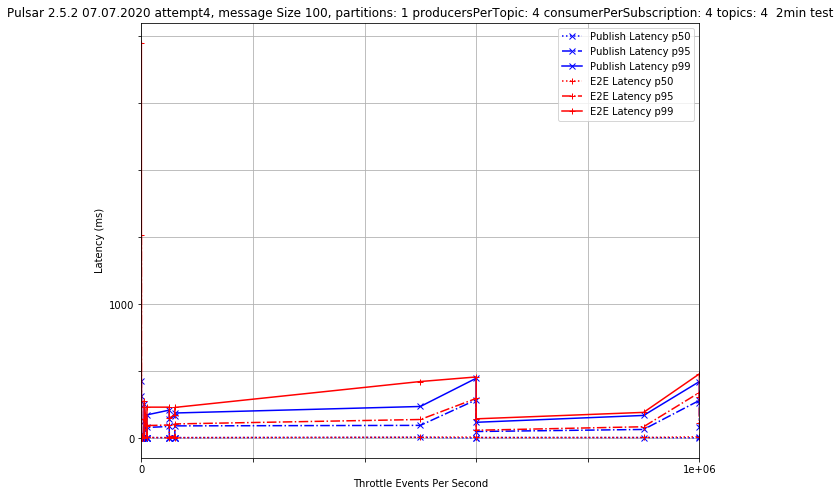

In [1220]:
plot_latency_vs_provided_rate_normal(filt_100_df)

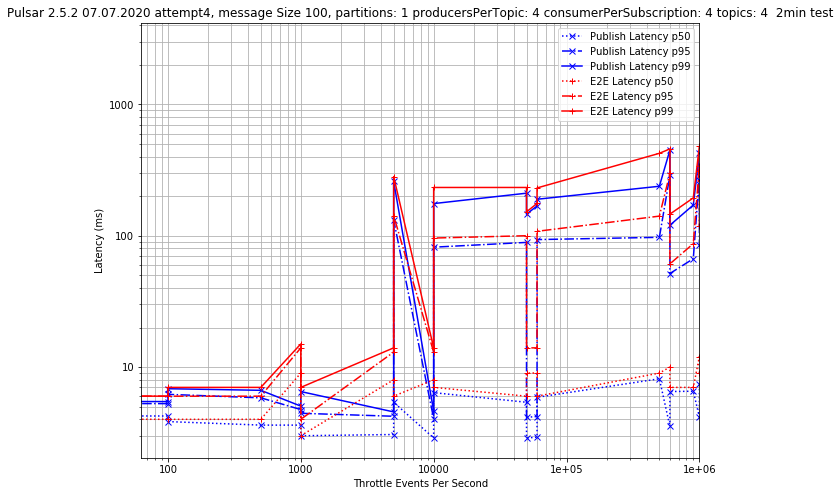

In [1221]:
plot_latency_vs_provided_rate(filt_100_df)

In [1222]:
latency_vs_provided_rate_table(filt_100_df)

,Publish Latency p50,Publish Latency p95,Publish Latency p99,E2E Latency p50,E2E Latency p95,E2E Latency p99,test_uuid
Throttle Events Per Second,,,,,,,
-1.0,30.307,315.741,430.219,237.0,1513.007,2949.007,1d84ea8d-e729-40a5-beb1-7db42d3391f4
100.0,4.239,5.266,5.459,4.0,6.000,6.000,17f06e5a-903e-4404-b8e7-889b598b7631
100.0,3.844,6.197,6.841,4.0,6.000,7.000,69e46b30-3626-4e3e-b38d-4eedb3a5028e
500.0,3.614,5.829,6.651,4.0,6.000,7.000,b5df29e4-14fd-4bd7-b69d-10c7d6a6847c
1000.0,3.613,4.745,5.041,9.0,14.000,15.000,242afdde-85be-48dd-9f36-5ebc2e0b988f
1000.0,2.999,4.447,6.506,3.0,4.000,7.000,9dadef8b-572f-428c-8900-03e5a0ac9f1c
5000.0,3.064,4.220,4.554,8.0,13.000,14.000,53705511-477f-4c93-b55b-78ba797318d7
5000.0,5.394,131.954,258.920,6.0,142.000,282.001,6bb93fc4-8720-4c01-9d74-3cfc61833c67
10000.0,2.884,4.044,4.615,8.0,13.000,14.000,21f6a538-6ad4-4b6e-9b9b-8b626030f261


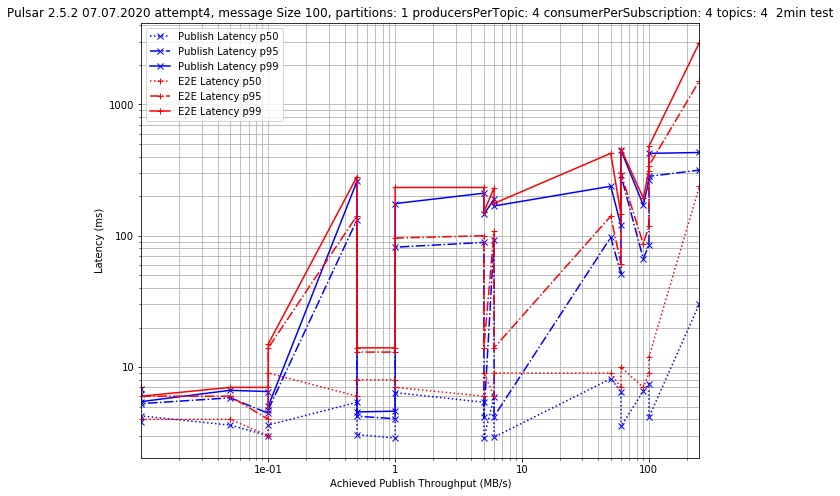

In [1223]:
plot_latency_vs_publish_throughput(filt_100_df)

In [1224]:
latency_vs_publish_throughput_table(filt_100_df)

,Publish Latency p50,Publish Latency p95,Publish Latency p99,E2E Latency p50,E2E Latency p95,E2E Latency p99,test_uuid
Achieved Publish Throughput (MB/s),,,,,,,
0.010013,3.844,6.197,6.841,4.0,6.000,7.000,69e46b30-3626-4e3e-b38d-4eedb3a5028e
0.010023,4.239,5.266,5.459,4.0,6.000,6.000,17f06e5a-903e-4404-b8e7-889b598b7631
0.050075,3.614,5.829,6.651,4.0,6.000,7.000,b5df29e4-14fd-4bd7-b69d-10c7d6a6847c
0.100154,2.999,4.447,6.506,3.0,4.000,7.000,9dadef8b-572f-428c-8900-03e5a0ac9f1c
0.100197,3.613,4.745,5.041,9.0,14.000,15.000,242afdde-85be-48dd-9f36-5ebc2e0b988f
0.500993,5.394,131.954,258.920,6.0,142.000,282.001,6bb93fc4-8720-4c01-9d74-3cfc61833c67
0.501138,3.064,4.220,4.554,8.0,13.000,14.000,53705511-477f-4c93-b55b-78ba797318d7
1.001955,2.884,4.044,4.615,8.0,13.000,14.000,21f6a538-6ad4-4b6e-9b9b-8b626030f261
1.002072,6.384,81.784,175.618,7.0,96.000,233.000,d4110a18-26c6-4d7b-a105-76154684f4fc


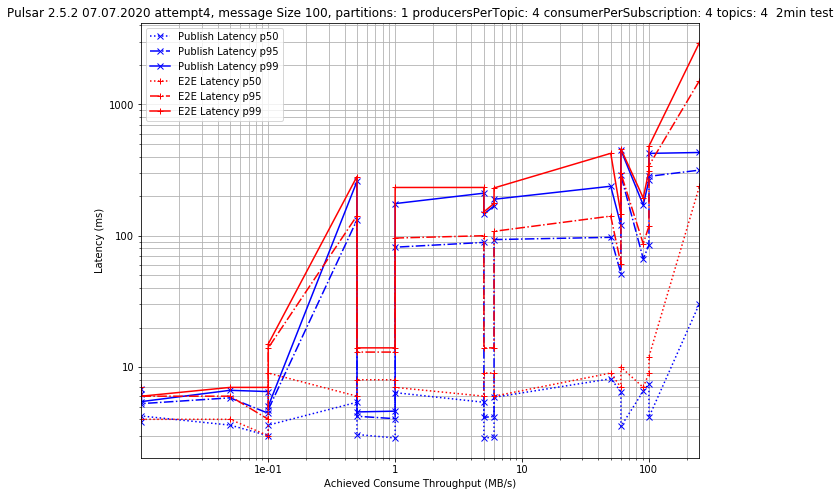

In [1225]:
plot_latency_vs_consume_throughput(filt_100_df)

In [1226]:
latency_vs_consume_throughput_table(filt_100_df)

,Publish Latency p50,Publish Latency p95,Publish Latency p99,E2E Latency p50,E2E Latency p95,E2E Latency p99,test_uuid
Achieved Consume Throughput (MB/s),,,,,,,
0.010013,3.844,6.197,6.841,4.0,6.000,7.000,69e46b30-3626-4e3e-b38d-4eedb3a5028e
0.010023,4.239,5.266,5.459,4.0,6.000,6.000,17f06e5a-903e-4404-b8e7-889b598b7631
0.050075,3.614,5.829,6.651,4.0,6.000,7.000,b5df29e4-14fd-4bd7-b69d-10c7d6a6847c
0.100155,2.999,4.447,6.506,3.0,4.000,7.000,9dadef8b-572f-428c-8900-03e5a0ac9f1c
0.100203,3.613,4.745,5.041,9.0,14.000,15.000,242afdde-85be-48dd-9f36-5ebc2e0b988f
0.501003,5.394,131.954,258.920,6.0,142.000,282.001,6bb93fc4-8720-4c01-9d74-3cfc61833c67
0.501127,3.064,4.220,4.554,8.0,13.000,14.000,53705511-477f-4c93-b55b-78ba797318d7
1.001999,2.884,4.044,4.615,8.0,13.000,14.000,21f6a538-6ad4-4b6e-9b9b-8b626030f261
1.002082,6.384,81.784,175.618,7.0,96.000,233.000,d4110a18-26c6-4d7b-a105-76154684f4fc


## Message Size 10 KB

In [1227]:
filt_10000_df = filter_dataframe(
    filt_df,
    messageSize=10000,
    producersPerTopic=4,
    partitionsPerTopic=1,
    numWorkloadWorkers=4,
    #version='2.6.0-not-tiered'
    #version='2.5.2'
)

In [1228]:
# View distinct sets of parameters.
# There should only be one distinct set of parameters.
filt_10000_df[param_cols].drop_duplicates().T

test_uuid,777ce55e-2451-472e-892f-4a90aef22490,5afc1c15-1721-4aba-9d29-c959d9320c74
numWorkloadWorkers,4,4
topics,4,4
partitionsPerTopic,1,1
producersPerTopic,4,4
subscriptionsPerTopic,1,1
consumerPerSubscription,4,4
testDurationMinutes,2,2
keyDistributor,NO_KEY,NO_KEY
git_commit,640ec1c,88dbf86
driverName,Pulsar,Pravega


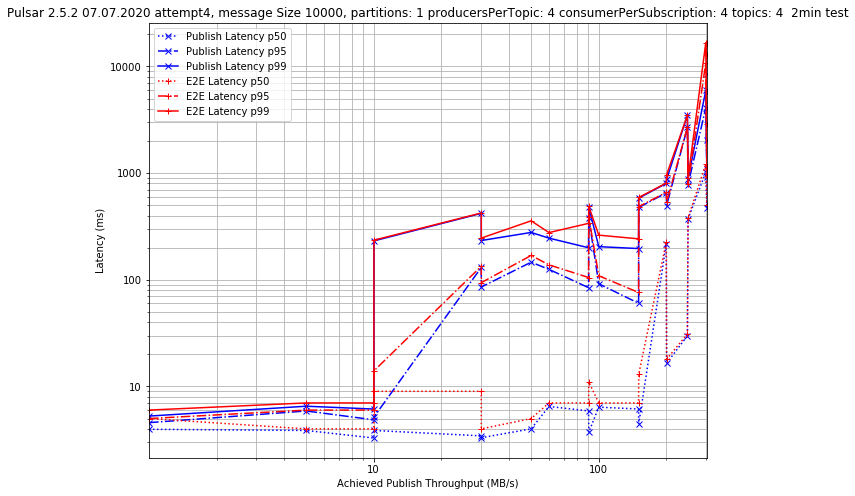

In [1229]:
plot_latency_vs_publish_throughput(filt_10000_df)

In [1230]:
latency_vs_publish_throughput_table(filt_10000_df)

,Publish Latency p50,Publish Latency p95,Publish Latency p99,E2E Latency p50,E2E Latency p95,E2E Latency p99,test_uuid
Achieved Publish Throughput (MB/s),,,,,,,
1.001395,3.964,4.575,5.271,5.000,5.000,6.000,5afc1c15-1721-4aba-9d29-c959d9320c74
5.006443,3.866,5.887,6.523,4.000,6.000,7.000,81d79f5c-2b89-4c1c-916d-1fd899bfc40c
10.011328,3.282,4.863,6.137,4.000,6.000,7.000,c0aedc56-8164-4af9-98c0-c509babb5ac6
10.022681,3.865,5.165,231.546,9.000,14.000,235.000,777ce55e-2451-472e-892f-4a90aef22490
30.079640,3.440,130.655,419.483,9.000,134.000,423.001,67ef1e42-9a1b-4c16-a44b-20e0f11b778f
30.086669,3.304,85.544,233.348,4.000,94.000,246.000,4e5bb630-2d28-4bd1-9838-f74db7d24b2c
50.114531,4.002,146.109,277.765,5.000,169.000,357.001,5aabde3d-7062-4a67-b133-b39a05a6e023
60.171285,6.486,125.147,245.671,7.000,138.000,277.001,8b122058-586e-4ec3-9664-1129487c8053
90.242925,5.894,84.259,199.605,7.000,105.000,338.001,7803b1fb-1147-4df2-8324-7cd45b545127


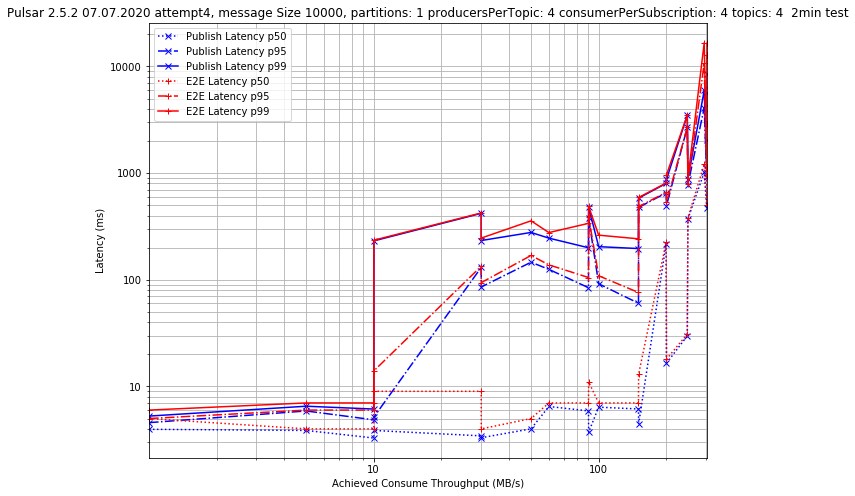

In [1231]:
plot_latency_vs_consume_throughput(filt_10000_df)

In [1232]:
latency_vs_consume_throughput_table(filt_10000_df)

,Publish Latency p50,Publish Latency p95,Publish Latency p99,E2E Latency p50,E2E Latency p95,E2E Latency p99,test_uuid
Achieved Consume Throughput (MB/s),,,,,,,
1.001312,3.964,4.575,5.271,5.000,5.000,6.000,5afc1c15-1721-4aba-9d29-c959d9320c74
5.006442,3.866,5.887,6.523,4.000,6.000,7.000,81d79f5c-2b89-4c1c-916d-1fd899bfc40c
10.011658,3.282,4.863,6.137,4.000,6.000,7.000,c0aedc56-8164-4af9-98c0-c509babb5ac6
10.022598,3.865,5.165,231.546,9.000,14.000,235.000,777ce55e-2451-472e-892f-4a90aef22490
30.079644,3.440,130.655,419.483,9.000,134.000,423.001,67ef1e42-9a1b-4c16-a44b-20e0f11b778f
30.086838,3.304,85.544,233.348,4.000,94.000,246.000,4e5bb630-2d28-4bd1-9838-f74db7d24b2c
50.115364,4.002,146.109,277.765,5.000,169.000,357.001,5aabde3d-7062-4a67-b133-b39a05a6e023
60.170126,6.486,125.147,245.671,7.000,138.000,277.001,8b122058-586e-4ec3-9664-1129487c8053
90.241525,5.894,84.259,199.605,7.000,105.000,338.001,7803b1fb-1147-4df2-8324-7cd45b545127


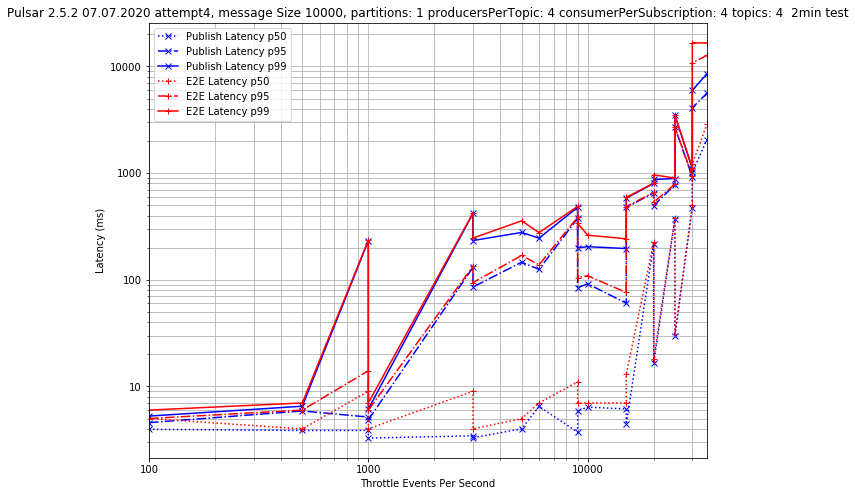

In [1233]:
plot_latency_vs_provided_rate(filt_10000_df)

In [1234]:
latency_vs_provided_rate_table(filt_10000_df)

,Publish Latency p50,Publish Latency p95,Publish Latency p99,E2E Latency p50,E2E Latency p95,E2E Latency p99,test_uuid
Throttle Events Per Second,,,,,,,
100.0,3.964,4.575,5.271,5.000,5.000,6.000,5afc1c15-1721-4aba-9d29-c959d9320c74
500.0,3.866,5.887,6.523,4.000,6.000,7.000,81d79f5c-2b89-4c1c-916d-1fd899bfc40c
1000.0,3.865,5.165,231.546,9.000,14.000,235.000,777ce55e-2451-472e-892f-4a90aef22490
1000.0,3.282,4.863,6.137,4.000,6.000,7.000,c0aedc56-8164-4af9-98c0-c509babb5ac6
3000.0,3.440,130.655,419.483,9.000,134.000,423.001,67ef1e42-9a1b-4c16-a44b-20e0f11b778f
3000.0,3.304,85.544,233.348,4.000,94.000,246.000,4e5bb630-2d28-4bd1-9838-f74db7d24b2c
5000.0,4.002,146.109,277.765,5.000,169.000,357.001,5aabde3d-7062-4a67-b133-b39a05a6e023
6000.0,6.486,125.147,245.671,7.000,138.000,277.001,8b122058-586e-4ec3-9664-1129487c8053
9000.0,3.727,377.117,477.669,11.000,386.001,487.001,e6110863-9623-4855-8f0a-cf77c865aad3


## Analyze 100 B events, 50,000 events/sec, various number of partitions and producers

In [1235]:
filt_50000eps_df = filter_dataframe(
    filt_df,
    messageSize=100,
    producerRate=-1,
).sort_values(['endToEndLatencyMs99Pct'], ascending=True)
len(filt_50000eps_df)

2

In [1236]:
take_varying_columns(filt_50000eps_df[cols]).head(20)

,partitionsPerTopic,publishRateEventsPerSecMean,consumeRateEventsPerSecMean,consumeRateMBPerSecMean,publishRateMBPerSecMean,publishLatencyMs50Pct,publishLatencyMs99Pct,endToEndLatencyMs50Pct,endToEndLatencyMs99Pct,utc_begin
test_uuid,,,,,,,,,,
1d84ea8d-e729-40a5-beb1-7db42d3391f4,1,2.503825e+06,2.504891e+06,250.489094,250.382502,30.307,430.219,237.000,2949.007,2020-06-17 08:10:28.226332+00:00
58640bcc-0d0c-4329-8e55-1f3ae7cb7517,16,2.169795e+06,2.897279e+05,28.972787,216.979518,12.594,405.701,108548.095,163322.879,2020-06-17 08:48:46.180976+00:00


# Analyze Latency Distribution

In [1237]:
test_uuid = filt_50000eps_df.iloc[0].name
test_uuid

'1d84ea8d-e729-40a5-beb1-7db42d3391f4'

In [1238]:
df = clean_df
t = df[df.test_uuid==test_uuid].iloc[0]

In [1239]:
# Cumulative Distribution Function
pubcdf = t.aggregatedPublishLatencyQuantiles
pubcdf.name = 'Publish Latency CDF'

In [1240]:
# Probability Distribution Function (latency histogram)
pubpdf = pd.Series(index=pubcdf.index, data=np.gradient(pubcdf, pubcdf.index.values), name='Publish Latency PDF')

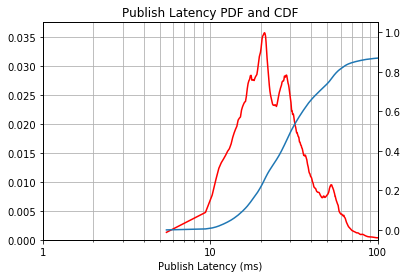

In [1241]:
fig0, ax0 = plt.subplots()
ax1 = ax0.twinx()
pubpdf.plot(ax=ax0, xlim=[1,100], ylim=[0,None], style='r', title='Publish Latency PDF and CDF')
pubcdf.plot(ax=ax1, xlim=[1,100], secondary_y=True, logx=True, ylim=[0,1])
# ax0.set_ylabel('PDF');
# ax1.set_ylabel('CDF');
ax0.set_xlabel('Publish Latency (ms)');
tick_formatter = matplotlib.ticker.LogFormatter()
ax0.xaxis.set_major_formatter(tick_formatter)
ax0.grid('on', which='both', axis='both')
plt.show()
plt.close()

In [1242]:
# Cumulative Distribution Function
e2ecdf = t.aggregatedEndToEndLatencyQuantiles
e2ecdf.name = 'E2E Latency CDF'
# Probability Distribution Function (latency histogram)
e2epdf = pd.Series(index=e2ecdf.index, data=np.gradient(e2ecdf, e2ecdf.index.values), name='E2E Latency PDF')

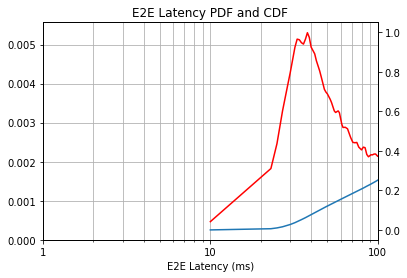

In [1243]:
fig0, ax0 = plt.subplots()
ax1 = ax0.twinx()
e2epdf.plot(ax=ax0, xlim=[1,100], ylim=[0,None], style='r', title='E2E Latency PDF and CDF')
e2ecdf.plot(ax=ax1, xlim=[1,100], secondary_y=True, logx=True, ylim=[0,1])
# ax0.set_ylabel('PDF');
# ax1.set_ylabel('CDF');
ax0.set_xlabel('E2E Latency (ms)');
tick_formatter = matplotlib.ticker.LogFormatter()
ax0.xaxis.set_major_formatter(tick_formatter)
ax0.grid('on', which='both', axis='both')
plt.show()
plt.close()

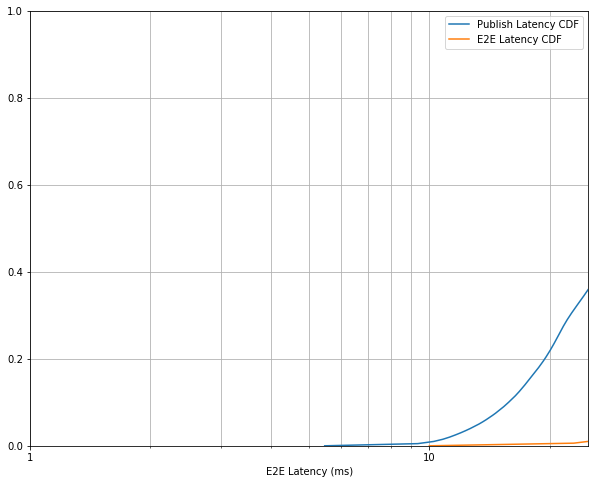

In [1244]:
# Combined publish and E2E latency CDF
fig0, ax0 = plt.subplots()
xlim=[1,25]
pubcdf.plot(ax=ax0, xlim=xlim, logx=True, ylim=[0,1], legend=True, figsize=(10,8))
e2ecdf.plot(ax=ax0, xlim=xlim, logx=True, ylim=[0,1], legend=True)
ax0.set_xlabel('E2E Latency (ms)');
tick_formatter = matplotlib.ticker.LogFormatter()
ax0.xaxis.set_major_formatter(tick_formatter)
ax0.grid('on', which='both', axis='both')
plt.show()
plt.close()

## Compare Two Sets

In [1256]:
# Common filter
filt_df = filter_dataframe(
    clean_df,
    numWorkloadWorkers=4, 
    topics=4,
    testDurationMinutes=2,
    #size_of_test_batch=(2,1000), # between
    #aggregatedEndToEndLatency50pct=(1,1e6),
    messageSize=10000,
    producersPerTopic=4,
    partitionsPerTopic=1,    
)
len(filt_df)

20

In [1257]:
# Set 1
filt1_df = filter_dataframe(
    filt_df,
    #version='2.6.0-not-tiered',
    pravegaVersion='0.8.0-2656.15b0f5eb9-no_netty-client-Isilon-tier2' 
    #pravegaVersion='0.8.0-2656.1c40f1e-Isilon-tier2',
)
len(filt1_df)

13

In [1258]:
# Set 2
filt2_df = filter_dataframe(
    filt_df,
    #version='2.6.0-ecs-s3-tier2'
    version='2.5.2',
    #pravegaVersion='0.8.0-2656.1c40f1e-Isilon-tier2',
)
len(filt2_df)

7

In [1259]:
dfs = [filt1_df, filt2_df]
take_varying_columns(pd.concat(dfs)[param_cols]).drop_duplicates()

,git_commit,driverName,version
test_uuid,,,
5afc1c15-1721-4aba-9d29-c959d9320c74,88dbf86,Pravega,0.8.0-2656.15b0f5eb9-no_netty-client-Isilon-tier2
777ce55e-2451-472e-892f-4a90aef22490,640ec1c,Pulsar,2.5.2


In [1260]:
def plot_latency_vs_throughput_comparison(dfs, legend_cols=None, latencyMetric='Publish'):
    fig0, ax0 = plt.subplots()
    cmap = plt.get_cmap('Set1')
    colors = cmap.colors[0:len(dfs)]
    pravegaVersion = filt1_df.version.iloc[0]
    pravegaDriver = filt1_df.driver.iloc[0]
    pulsarVersion = filt2_df.version.iloc[0]
    pulsaraDriver = filt2_df.driver.iloc[0]
    messageSize = filt2_df.messageSize.iloc[0]
    msgSize = '%db' % (messageSize)
    if messageSize >= 1000:
        msgSize = '%dk' % (messageSize/1000)
    
    partitionsPerTopic = filt2_df.partitionsPerTopic.iloc[0]
    testDurationMinutes = filt2_df.testDurationMinutes.iloc[0]
    topics = filt2_df.topics.iloc[0]
    producersPerTopic = filt2_df.producersPerTopic.iloc[0]
    consumerPerSubscription = filt2_df.consumerPerSubscription.iloc[0]
    
    title = 'Compare %s %s and %s %s [messageSize %s, partitions: %d producersPerTopic: %d consumerPerSubscription: %d topics: %d] on %d min test' % (pravegaDriver, pravegaVersion, pulsaraDriver, pulsarVersion, msgSize, partitionsPerTopic, producersPerTopic, consumerPerSubscription, topics, testDurationMinutes)
   
    for index, (df, color) in enumerate(zip(dfs, colors)):
        df = df.set_index(['publishRateMBPerSecMean']).sort_index()
        name_cols = df.iloc[0][legend_cols]
        name = ','.join(['%s=%s' % item for item in name_cols.to_dict().items()])
    
        plot_df = latency_vs_provided_rate_table(df)
        
        for percentile, style in [('50',':x'), ('95','-.x'), ('99','-x')]:
            plot_df = df[['aggregated%sLatency%spct' % (latencyMetric, percentile)]]
            plot_df.columns = ['%s %s Latency p%s' % (name, latencyMetric, percentile)]
            plot_df.index.name = 'Achieved Publish Throughput (MB/s)'
            plot_df.plot(
                ax=ax0,
                logx=True, 
                logy=True,
                figsize=(10,8),
                grid=True,
                style=style,
                color=color,
                title=title 
            )
    ax0.set_ylabel('Latency (ms)');
    tick_formatter = matplotlib.ticker.LogFormatter()
    ax0.xaxis.set_major_formatter(tick_formatter)
    ax0.yaxis.set_major_formatter(tick_formatter)
    ax0.grid('on', which='both', axis='both')

In [1261]:
def plot_latency_vs_provided_rate_comparison(dfs, legend_cols=None, latencyMetric='Publish'):
    fig0, ax0 = plt.subplots()
    cmap = plt.get_cmap('Set1')
    colors = cmap.colors[0:len(dfs)]
    pravegaVersion = filt1_df.version.iloc[0]
    pravegaDriver = filt1_df.driver.iloc[0]
    pulsarVersion = filt2_df.version.iloc[0]
    pulsaraDriver = filt2_df.driver.iloc[0]
    messageSize = filt2_df.messageSize.iloc[0]
    msgSize = '%db' % (messageSize)
    if messageSize >= 1000:
        msgSize = '%dk' % (messageSize/1000)
    
    partitionsPerTopic = filt2_df.partitionsPerTopic.iloc[0]
    testDurationMinutes = filt2_df.testDurationMinutes.iloc[0]
    topics = filt2_df.topics.iloc[0]
    producersPerTopic = filt2_df.producersPerTopic.iloc[0]
    consumerPerSubscription = filt2_df.consumerPerSubscription.iloc[0]
    
    title = 'Compare %s %s and %s %s [messageSize %s, partitions: %d producersPerTopic: %d consumerPerSubscription: %d topics: %d] on %d min test' % (pravegaDriver, pravegaVersion, pulsaraDriver, pulsarVersion, msgSize, partitionsPerTopic, producersPerTopic, consumerPerSubscription, topics, testDurationMinutes)
    
    for index, (df, color) in enumerate(zip(dfs, colors)):
        df = df.set_index(['throttleEventsPerSec']).sort_index()
        name_cols = df.iloc[0][legend_cols]
        name = ','.join(['%s=%s' % item for item in name_cols.to_dict().items()])
               
        for percentile, style in [('50',':x'), ('95','-.x'), ('99','-x')]:
            plot_df = df[['aggregated%sLatency%spct' % (latencyMetric, percentile)]]
            plot_df.columns = ['%s %s Latency p%s' % (name, latencyMetric, percentile)]
            plot_df.index.name = 'Provided Rate (Events/s)'
            plot_df.plot(
                ax=ax0,
                logx=True, 
                logy=True,
                figsize=(10,8),
                grid=True,
                style=style,
                color=color,
                title=title 
            )
    ax0.set_ylabel('Latency (ms)');
    tick_formatter = matplotlib.ticker.LogFormatter()
    ax0.xaxis.set_major_formatter(tick_formatter)
    ax0.yaxis.set_major_formatter(tick_formatter)
    ax0.grid('on', which='both', axis='both')

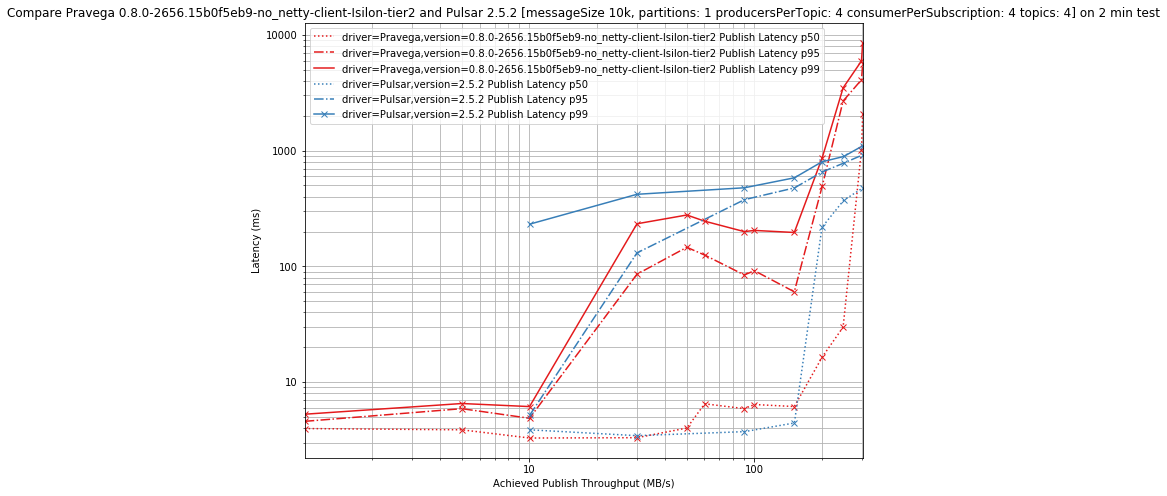

In [1262]:
plot_latency_vs_throughput_comparison([filt1_df, filt2_df], legend_cols=['driver', 'version'], latencyMetric='Publish')

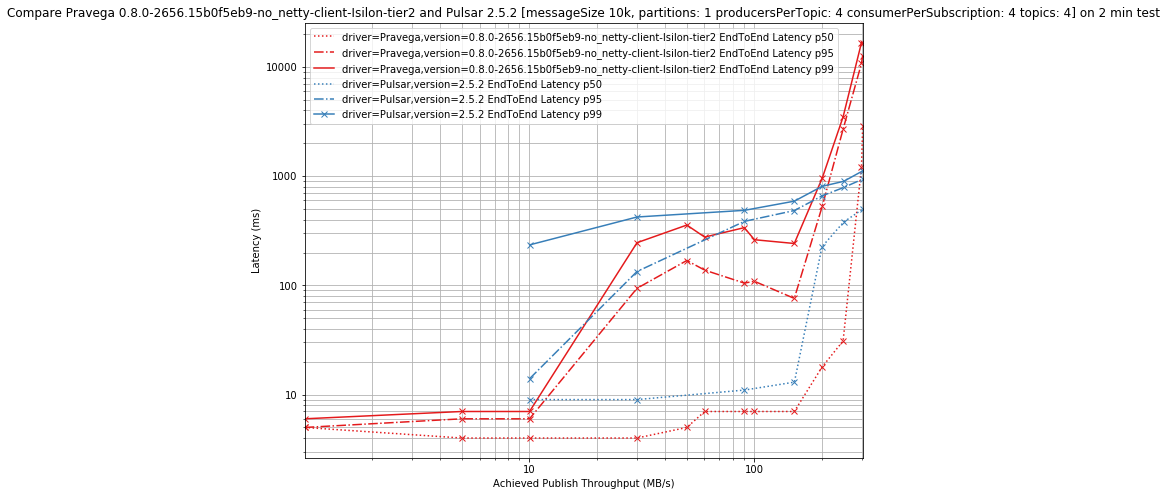

In [1263]:
plot_latency_vs_throughput_comparison([filt1_df, filt2_df], legend_cols=['driver', 'version'], latencyMetric='EndToEnd')

In [1264]:
### Latency vs Provided Rate 

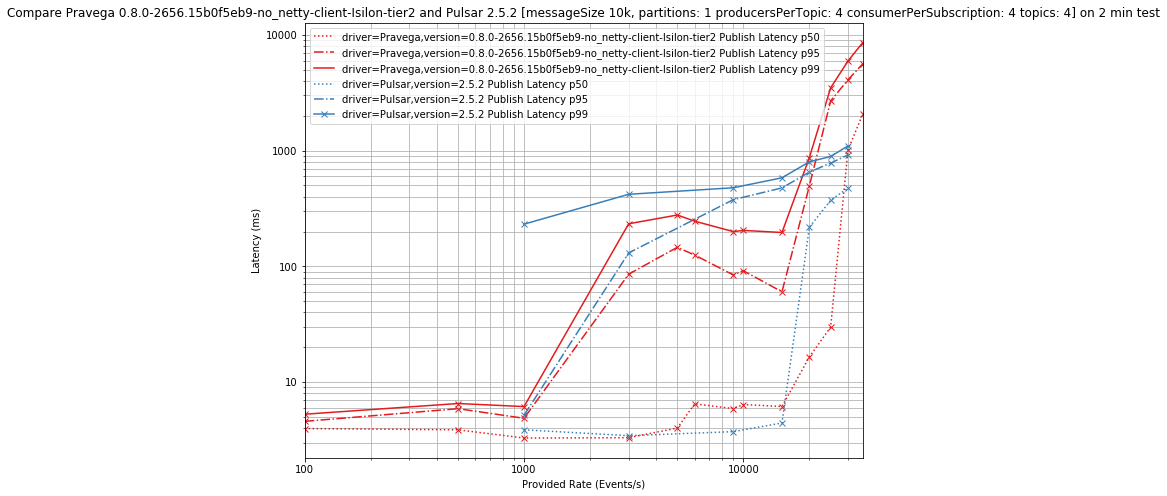

In [1265]:
plot_latency_vs_provided_rate_comparison([filt1_df, filt2_df], legend_cols=['driver', 'version'], latencyMetric='Publish')

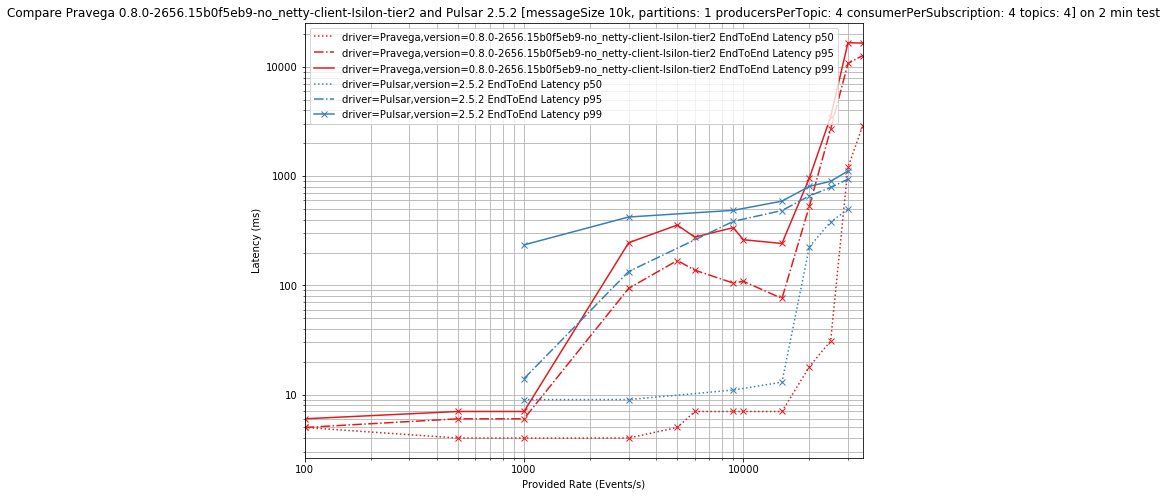

In [1266]:
plot_latency_vs_provided_rate_comparison([filt1_df, filt2_df], legend_cols=['driver', 'version'], latencyMetric='EndToEnd')